# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [11]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [12]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [14]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.final #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [20]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [21]:
count = 100 #number of returned tweets, default and max is 100
geocode = "33.7672884,-84.5602157,50mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [22]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 28 20:53:25 +0000 2022'
'Mon Nov 28 20:48:06 +0000 2022'
'Mon Nov 28 20:47:23 +0000 2022'
'Mon Nov 28 20:46:10 +0000 2022'
'Mon Nov 28 20:42:50 +0000 2022'
'Mon Nov 28 20:42:23 +0000 2022'
'Mon Nov 28 20:41:57 +0000 2022'
'Mon Nov 28 20:41:38 +0000 2022'
'Mon Nov 28 20:37:34 +0000 2022'
'Mon Nov 28 20:37:32 +0000 2022'
'Mon Nov 28 20:32:38 +0000 2022'
'Mon Nov 28 20:32:02 +0000 2022'
'Mon Nov 28 20:28:13 +0000 2022'
'Mon Nov 28 20:26:55 +0000 2022'
'Mon Nov 28 20:25:26 +0000 2022'
'Mon Nov 28 20:24:32 +0000 2022'
'Mon Nov 28 20:21:27 +0000 2022'
'Mon Nov 28 20:20:18 +0000 2022'
'Mon Nov 28 20:19:43 +0000 2022'
'Mon Nov 28 20:16:49 +0000 2022'
'Mon Nov 28 20:15:48 +0000 2022'
'Mon Nov 28 20:15:00 +0000 2022'
'Mon Nov 28 20:12:43 +0000 2022'
'Mon Nov 28 20:09:18 +0000 2022'
'Mon Nov 28 20:09:10 +0000 2022'
'Mon Nov 28 20:09:06 +0000 2022'
'Mon Nov 28 19:54:54 +0000 2022'
'Mon Nov 28 19:54:44 +0000 2022'
'Mon Nov 28 19:53:39 +0000 2022'
'Mon Nov 28 19:52:41 +0000 2022'
'Mon Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [23]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 28 17:29:27 +0000 2022'
'Mon Nov 28 17:28:28 +0000 2022'
'Mon Nov 28 17:26:22 +0000 2022'
'Mon Nov 28 17:21:17 +0000 2022'
'Mon Nov 28 17:19:37 +0000 2022'
'Mon Nov 28 17:19:33 +0000 2022'
'Mon Nov 28 17:13:09 +0000 2022'
'Mon Nov 28 17:10:32 +0000 2022'
'Mon Nov 28 17:09:44 +0000 2022'
'Mon Nov 28 17:06:51 +0000 2022'
'Mon Nov 28 17:03:36 +0000 2022'
'Mon Nov 28 17:03:30 +0000 2022'
'Mon Nov 28 17:02:42 +0000 2022'
'Mon Nov 28 16:55:06 +0000 2022'
'Mon Nov 28 16:54:06 +0000 2022'
'Mon Nov 28 16:52:50 +0000 2022'
'Mon Nov 28 16:51:47 +0000 2022'
'Mon Nov 28 16:49:10 +0000 2022'
'Mon Nov 28 16:44:40 +0000 2022'
'Mon Nov 28 16:40:57 +0000 2022'
'Mon Nov 28 16:37:40 +0000 2022'
'Mon Nov 28 16:37:37 +0000 2022'
'Mon Nov 28 16:30:59 +0000 2022'
'Mon Nov 28 16:27:51 +0000 2022'
'Mon Nov 28 16:26:24 +0000 2022'
'Mon Nov 28 16:24:05 +0000 2022'
'Mon Nov 28 16:21:47 +0000 2022'
'Mon Nov 28 16:19:25 +0000 2022'
'Mon Nov 28 16:15:12 +0000 2022'
'Mon Nov 28 16:11:18 +0000 2022'
'Mon Nov 2

'Sun Nov 27 20:11:56 +0000 2022'
'Sun Nov 27 20:09:32 +0000 2022'
'Sun Nov 27 20:07:56 +0000 2022'
'Sun Nov 27 20:02:49 +0000 2022'
'Sun Nov 27 19:58:12 +0000 2022'
'Sun Nov 27 19:57:40 +0000 2022'
'Sun Nov 27 19:55:21 +0000 2022'
'Sun Nov 27 19:47:00 +0000 2022'
'Sun Nov 27 19:46:41 +0000 2022'
'Sun Nov 27 19:46:22 +0000 2022'
'Sun Nov 27 19:38:50 +0000 2022'
'Sun Nov 27 19:24:05 +0000 2022'
'Sun Nov 27 19:21:52 +0000 2022'
'Sun Nov 27 19:16:38 +0000 2022'
'Sun Nov 27 19:16:33 +0000 2022'
'Sun Nov 27 19:15:41 +0000 2022'
'Sun Nov 27 19:14:05 +0000 2022'
'Sun Nov 27 19:05:48 +0000 2022'
'Sun Nov 27 19:02:56 +0000 2022'
'Sun Nov 27 19:02:21 +0000 2022'
'Sun Nov 27 19:01:39 +0000 2022'
'Sun Nov 27 19:01:15 +0000 2022'
'Sun Nov 27 18:58:10 +0000 2022'
'Sun Nov 27 18:52:44 +0000 2022'
'Sun Nov 27 18:47:12 +0000 2022'
'Sun Nov 27 18:39:33 +0000 2022'
'Sun Nov 27 18:38:34 +0000 2022'
'Sun Nov 27 18:37:25 +0000 2022'
'Sun Nov 27 18:35:24 +0000 2022'
'Sun Nov 27 18:35:05 +0000 2022'
'Sun Nov 2

'Sat Nov 26 19:10:21 +0000 2022'
'Sat Nov 26 19:04:10 +0000 2022'
'Sat Nov 26 19:01:03 +0000 2022'
'Sat Nov 26 18:58:56 +0000 2022'
'Sat Nov 26 18:57:03 +0000 2022'
'Sat Nov 26 18:48:39 +0000 2022'
'Sat Nov 26 18:46:48 +0000 2022'
'Sat Nov 26 18:46:38 +0000 2022'
'Sat Nov 26 18:45:23 +0000 2022'
'Sat Nov 26 18:43:59 +0000 2022'
'Sat Nov 26 18:42:07 +0000 2022'
'Sat Nov 26 18:36:59 +0000 2022'
'Sat Nov 26 18:30:08 +0000 2022'
'Sat Nov 26 18:25:03 +0000 2022'
'Sat Nov 26 18:22:14 +0000 2022'
'Sat Nov 26 18:17:16 +0000 2022'
'Sat Nov 26 18:16:55 +0000 2022'
'Sat Nov 26 18:12:15 +0000 2022'
'Sat Nov 26 18:10:45 +0000 2022'
'Sat Nov 26 18:08:25 +0000 2022'
'Sat Nov 26 18:07:41 +0000 2022'
'Sat Nov 26 18:07:20 +0000 2022'
'Sat Nov 26 18:02:08 +0000 2022'
'Sat Nov 26 18:00:46 +0000 2022'
'Sat Nov 26 18:00:25 +0000 2022'
'Sat Nov 26 18:00:24 +0000 2022'
'Sat Nov 26 17:58:34 +0000 2022'
'Sat Nov 26 17:52:38 +0000 2022'
'Sat Nov 26 17:46:25 +0000 2022'
'Sat Nov 26 17:39:30 +0000 2022'
'Sat Nov 2

'Fri Nov 25 13:18:29 +0000 2022'
'Fri Nov 25 13:13:12 +0000 2022'
'Fri Nov 25 13:11:05 +0000 2022'
'Fri Nov 25 13:07:45 +0000 2022'
'Fri Nov 25 12:55:12 +0000 2022'
'Fri Nov 25 12:49:21 +0000 2022'
'Fri Nov 25 12:16:42 +0000 2022'
'Fri Nov 25 12:00:32 +0000 2022'
'Fri Nov 25 10:56:50 +0000 2022'
'Fri Nov 25 10:47:12 +0000 2022'
'Fri Nov 25 10:32:04 +0000 2022'
'Fri Nov 25 10:13:17 +0000 2022'
'Fri Nov 25 10:04:05 +0000 2022'
'Fri Nov 25 08:20:57 +0000 2022'
'Fri Nov 25 08:14:01 +0000 2022'
'Fri Nov 25 07:30:49 +0000 2022'
'Fri Nov 25 07:07:06 +0000 2022'
'Fri Nov 25 06:29:17 +0000 2022'
'Fri Nov 25 06:12:10 +0000 2022'
'Fri Nov 25 05:41:16 +0000 2022'
'Fri Nov 25 04:50:34 +0000 2022'
'Fri Nov 25 04:43:48 +0000 2022'
'Fri Nov 25 03:47:17 +0000 2022'
'Fri Nov 25 03:47:12 +0000 2022'
'Fri Nov 25 03:36:30 +0000 2022'
'Fri Nov 25 03:33:53 +0000 2022'
'Fri Nov 25 03:30:29 +0000 2022'
'Fri Nov 25 03:21:53 +0000 2022'
'Fri Nov 25 03:15:26 +0000 2022'
'Fri Nov 25 03:08:46 +0000 2022'
'Fri Nov 2

'Thu Nov 24 01:06:03 +0000 2022'
'Thu Nov 24 00:56:06 +0000 2022'
'Thu Nov 24 00:54:54 +0000 2022'
'Thu Nov 24 00:53:00 +0000 2022'
'Thu Nov 24 00:44:00 +0000 2022'
'Thu Nov 24 00:43:09 +0000 2022'
'Thu Nov 24 00:41:04 +0000 2022'
'Thu Nov 24 00:33:03 +0000 2022'
'Thu Nov 24 00:28:40 +0000 2022'
'Thu Nov 24 00:25:19 +0000 2022'
'Thu Nov 24 00:17:39 +0000 2022'
'Thu Nov 24 00:16:33 +0000 2022'
'Thu Nov 24 00:16:00 +0000 2022'
'Thu Nov 24 00:15:24 +0000 2022'
'Thu Nov 24 00:14:03 +0000 2022'
'Thu Nov 24 00:08:37 +0000 2022'
'Wed Nov 23 23:58:19 +0000 2022'
'Wed Nov 23 23:42:03 +0000 2022'
'Wed Nov 23 23:41:10 +0000 2022'
'Wed Nov 23 23:37:05 +0000 2022'
'Wed Nov 23 23:33:55 +0000 2022'
'Wed Nov 23 23:33:21 +0000 2022'
'Wed Nov 23 23:33:11 +0000 2022'
'Wed Nov 23 23:31:29 +0000 2022'
'Wed Nov 23 23:31:15 +0000 2022'
'Wed Nov 23 23:30:50 +0000 2022'
'Wed Nov 23 23:30:31 +0000 2022'
'Wed Nov 23 23:25:31 +0000 2022'
'Wed Nov 23 23:24:24 +0000 2022'
'Wed Nov 23 23:22:00 +0000 2022'
'Wed Nov 2

'Wed Nov 23 04:24:42 +0000 2022'
'Wed Nov 23 04:18:53 +0000 2022'
'Wed Nov 23 04:17:19 +0000 2022'
'Wed Nov 23 03:59:48 +0000 2022'
'Wed Nov 23 03:47:02 +0000 2022'
'Wed Nov 23 03:39:55 +0000 2022'
'Wed Nov 23 03:39:44 +0000 2022'
'Wed Nov 23 03:35:09 +0000 2022'
'Wed Nov 23 03:32:14 +0000 2022'
'Wed Nov 23 03:31:09 +0000 2022'
'Wed Nov 23 03:27:43 +0000 2022'
'Wed Nov 23 03:24:02 +0000 2022'
'Wed Nov 23 03:11:32 +0000 2022'
'Wed Nov 23 03:09:25 +0000 2022'
'Wed Nov 23 03:07:36 +0000 2022'
'Wed Nov 23 02:49:20 +0000 2022'
'Wed Nov 23 02:48:26 +0000 2022'
'Wed Nov 23 02:42:59 +0000 2022'
'Wed Nov 23 02:39:33 +0000 2022'
'Wed Nov 23 02:38:58 +0000 2022'
'Wed Nov 23 02:38:03 +0000 2022'
'Wed Nov 23 02:36:20 +0000 2022'
'Wed Nov 23 02:35:58 +0000 2022'
'Wed Nov 23 02:35:41 +0000 2022'
'Wed Nov 23 02:34:35 +0000 2022'
'Wed Nov 23 02:30:28 +0000 2022'
'Wed Nov 23 02:21:52 +0000 2022'
'Wed Nov 23 02:13:13 +0000 2022'
'Wed Nov 23 02:06:20 +0000 2022'
'Wed Nov 23 01:55:19 +0000 2022'
'Wed Nov 2

'Tue Nov 22 16:46:17 +0000 2022'
'Tue Nov 22 16:45:56 +0000 2022'
'Tue Nov 22 16:42:07 +0000 2022'
'Tue Nov 22 16:37:26 +0000 2022'
'Tue Nov 22 16:36:56 +0000 2022'
'Tue Nov 22 16:34:49 +0000 2022'
'Tue Nov 22 16:30:58 +0000 2022'
'Tue Nov 22 16:30:00 +0000 2022'
'Tue Nov 22 16:27:38 +0000 2022'
'Tue Nov 22 16:25:37 +0000 2022'
'Tue Nov 22 16:18:51 +0000 2022'
'Tue Nov 22 16:14:30 +0000 2022'
'Tue Nov 22 16:13:38 +0000 2022'
'Tue Nov 22 16:04:34 +0000 2022'
'Tue Nov 22 16:04:07 +0000 2022'
'Tue Nov 22 16:02:47 +0000 2022'
'Tue Nov 22 16:01:26 +0000 2022'
'Tue Nov 22 16:01:07 +0000 2022'
'Tue Nov 22 15:54:21 +0000 2022'
'Tue Nov 22 15:54:03 +0000 2022'
'Tue Nov 22 15:52:38 +0000 2022'
'Tue Nov 22 15:52:09 +0000 2022'
'Tue Nov 22 15:49:11 +0000 2022'
'Tue Nov 22 15:48:04 +0000 2022'
'Tue Nov 22 15:47:39 +0000 2022'
'Tue Nov 22 15:42:09 +0000 2022'
'Tue Nov 22 15:39:21 +0000 2022'
'Tue Nov 22 15:33:14 +0000 2022'
'Tue Nov 22 15:31:39 +0000 2022'
'Tue Nov 22 15:28:23 +0000 2022'
'Tue Nov 2

'Mon Nov 21 20:46:18 +0000 2022'
'Mon Nov 21 20:39:49 +0000 2022'
'Mon Nov 21 20:34:58 +0000 2022'
'Mon Nov 21 20:34:39 +0000 2022'
'Mon Nov 21 20:33:12 +0000 2022'
'Mon Nov 21 20:33:02 +0000 2022'
'Mon Nov 21 20:32:41 +0000 2022'
'Mon Nov 21 20:32:00 +0000 2022'
'Mon Nov 21 20:29:58 +0000 2022'
'Mon Nov 21 20:25:24 +0000 2022'
'Mon Nov 21 20:23:26 +0000 2022'
'Mon Nov 21 20:19:37 +0000 2022'
'Mon Nov 21 20:19:18 +0000 2022'
'Mon Nov 21 20:15:13 +0000 2022'
'Mon Nov 21 20:13:50 +0000 2022'
'Mon Nov 21 20:10:04 +0000 2022'
'Mon Nov 21 20:07:14 +0000 2022'
'Mon Nov 21 19:59:42 +0000 2022'
'Mon Nov 21 19:57:59 +0000 2022'
'Mon Nov 21 19:48:25 +0000 2022'
'Mon Nov 21 19:45:36 +0000 2022'
'Mon Nov 21 19:44:48 +0000 2022'
'Mon Nov 21 19:41:18 +0000 2022'
'Mon Nov 21 19:38:06 +0000 2022'
'Mon Nov 21 19:37:22 +0000 2022'
'Mon Nov 21 19:35:56 +0000 2022'
'Mon Nov 21 19:30:46 +0000 2022'
'Mon Nov 21 19:28:43 +0000 2022'
'Mon Nov 21 19:15:51 +0000 2022'
'Mon Nov 21 19:15:35 +0000 2022'
'Mon Nov 2

'Sun Nov 20 23:19:49 +0000 2022'
'Sun Nov 20 23:15:13 +0000 2022'
'Sun Nov 20 23:08:44 +0000 2022'
'Sun Nov 20 23:04:55 +0000 2022'
'Sun Nov 20 22:54:41 +0000 2022'
'Sun Nov 20 22:48:37 +0000 2022'
'Sun Nov 20 22:47:32 +0000 2022'
'Sun Nov 20 22:41:31 +0000 2022'
'Sun Nov 20 22:40:27 +0000 2022'
'Sun Nov 20 22:39:45 +0000 2022'
'Sun Nov 20 22:38:35 +0000 2022'
'Sun Nov 20 22:26:36 +0000 2022'
'Sun Nov 20 22:24:05 +0000 2022'
'Sun Nov 20 22:20:44 +0000 2022'
'Sun Nov 20 22:02:40 +0000 2022'
'Sun Nov 20 21:58:15 +0000 2022'
'Sun Nov 20 21:55:38 +0000 2022'
'Sun Nov 20 21:53:49 +0000 2022'
'Sun Nov 20 21:52:12 +0000 2022'
'Sun Nov 20 21:43:32 +0000 2022'
'Sun Nov 20 21:40:09 +0000 2022'
'Sun Nov 20 21:35:03 +0000 2022'
'Sun Nov 20 21:28:03 +0000 2022'
'Sun Nov 20 21:27:19 +0000 2022'
'Sun Nov 20 21:25:30 +0000 2022'
'Sun Nov 20 21:22:16 +0000 2022'
'Sun Nov 20 21:21:18 +0000 2022'
'Sun Nov 20 21:19:37 +0000 2022'
'Sun Nov 20 21:19:10 +0000 2022'
'Sun Nov 20 21:17:14 +0000 2022'
'Sun Nov 2

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [24]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2752
1522


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Goldi Gaines
text: Vote  Vote Vote! Election Day is almost here and early Voting has already begun! To find a location near visit… https://t.co/DqlNi1ct98
----
name: 🇺🇸 Buck Joe Fiden 🇺🇸 ULTRA MAGA
text: @ProudElephantUS I vote on election day in person. Early voting and mail in voting is how they cheat!
----
name: IAFF Local 2498
text: Reminder to make plans to VOTE on November 8th 2022. or VOTE Early. EARLY VOTING IN-PERSON
You can vote early at yo… https://t.co/WX4b7B8uN3
----
name: Jeffrey D. Willard
text: @JoeBiden Voting On Election Day like I hope EVERYBODY
does who is a Legal Citizen(Early voting, OK fwiw)! VOTE!
----
name: Goldi Gaines
text: Say yes to voting. Tomorrow is Election Day get your vote in. Your vote is your voice. Here is a link to find a loc… https://t.co/w7cKzEC3l3
----
name: Charlottesville Dems
text: Saturday voting this weekend. Saturday will be the last day of early voting. Next and last opportunity to vote is E… https://t.co/heOPKFxnwX
----
name:

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,636960bb10aada83feef018b,Tue Nov 01 14:34:38 +0000 2022,1587453065728335873,1587453065728335873,Vote Vote Vote! Election Day is almost here a...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,18,27,False,False,False,en,NaN,NaN,NaN,NaN
1,636960af10aada83feeeff29,Fri Nov 04 20:27:07 +0000 2022,1588628931737161729,1588628931737161729,@ProudElephantUS I vote on election day in per...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.588616e+18,...,0,5,False,False,NaN,en,NaN,NaN,NaN,NaN
2,636960b110aada83feeeff7b,Fri Nov 04 13:45:57 +0000 2022,1588527975531974656,1588527975531974656,Reminder to make plans to VOTE on November 8th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,7,False,False,False,en,NaN,NaN,NaN,NaN
3,636960bd10aada83feef01d7,Mon Oct 31 20:43:43 +0000 2022,1587183557600067584,1587183557600067584,@JoeBiden Voting On Election Day like I hope E...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.587148e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
4,63695e9310aada83feeefd63,Mon Nov 07 18:57:40 +0000 2022,1589693583409352706,1589693583409352706,Say yes to voting. Tomorrow is Election Day ge...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3,2,False,False,False,en,NaN,NaN,NaN,NaN
5,636960b510aada83feef0048,Thu Nov 03 13:43:00 +0000 2022,1588164844632645634,1588164844632645634,Saturday voting this weekend. Saturday will be...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,4,False,False,False,en,NaN,NaN,NaN,NaN
6,63695e9410aada83feeefd99,Mon Nov 07 16:09:08 +0000 2022,1589651173774184448,1589651173774184448,Tomorrow is Election Day! If you haven’t voted...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.hubspot.com/"" rel=""nofollo...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
7,636960b110aada83feeeff68,Fri Nov 04 15:13:14 +0000 2022,1588549941194260480,1588549941194260480,I’ve voted a split ticket in every election si...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
8,636960b310aada83feeeffe5,Thu Nov 03 21:49:13 +0000 2022,1588287206686224387,1588287206686224387,@ArkansasBlog Republicans vote on Election Day...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.588267e+18,...,0,4,False,False,NaN,en,NaN,NaN,NaN,NaN
9,636960ab10aada83feeefe3b,Sun Nov 06 17:21:16 +0000 2022,1589306939103907841,1589306939103907841,@joncoopertweets How many are dead voting this...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.589237e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN


<AxesSubplot:>

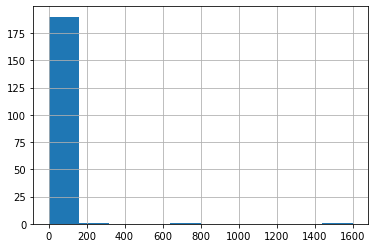

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count